# Swapping Convolution Layers Test
April 26, 2024

##### Summary:
Swap first 50 layers between FAT and FedAvg models of CIFAR-10 data set and measure test acc + robustness. The goal is to see if injecting a fraction of the model via ARU can reduce robustness of it significantly

In [2]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [3]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

In [4]:
setting, num_user = "FedAvg_adv", 40

try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user)

# Load models for FAT and FedAvg
save_path_FAT = 'weights/cifar10/230922_baseline_train/FAT/'
save_path_FedAvg = 'weights/cifar10/230922_baseline_train/fedavg/'

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0]


==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 131.41it/s]


===> Initializing clients..


100%|██████████| 40/40 [00:21<00:00,  1.90it/s]


In [5]:
# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key]

In [17]:
# Gather statistics layer by layer
# 1. Number of paramters per layer
# 2. Standard Deviation per layer 
# 3. Difference between np.mean layer(FedAvg - FAT) * num param

num_params_list = []
std_params_list_FedAvg = []
std_params_list_FAT = []
diff_normalized = []

for key in desired_keys:
    mat_FedAvg = params_FedAvg[key]
    mat_FAT = params_FAT[key]
    num_params = params_FedAvg[key].numel()
    num_params_list += [num_params]


    if num_params > 1:
        std_params = torch.std(mat_FedAvg)
        std_params_list_FedAvg += [std_params]
        std_params_list_FAT += [torch.std(mat_FAT)]
        diff_normalized += [torch.mean(torch.abs(mat_FedAvg - mat_FAT)/std_params)]
    else:
        std_params_list_FedAvg += [0]
        std_params_list_FAT += [0]
        diff_normalized += [torch.abs(mat_FedAvg - mat_FAT)]




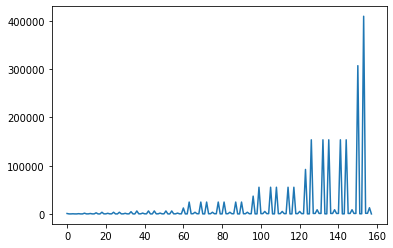

In [18]:

plt.plot(num_params_list)

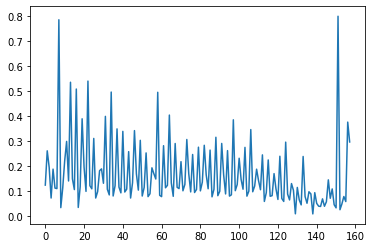

In [19]:
list_of_doubles = [tensor.item() for tensor in diff_normalized]
plt.plot(list_of_doubles)

In [10]:
# Linear extrapolation of model for each layer
stepsize_alpha = 0.05
alpha_set = np.arange(0,1+stepsize_alpha,stepsize_alpha)

params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Make the model with just 50 first layers
new_model = copy.deepcopy(model_FAT)
new_model.eval()
new_weight_dict = copy.deepcopy(params_FAT)

counter = 0
threshold = 50
for key in params_FAT:
    new_weight_dict[key] = params_FedAvg[key]
    counter += 1
    if counter >= threshold:
        break

new_model.load_state_dict(new_weight_dict)

models_test = [model_Fedavg, model_FAT, new_model]


In [11]:
# Perform transfer attack from one client to another and record stats
# models_test = [model_Fedavg, model_FAT]

num_trials = 5
acc_store_agg = np.zeros([num_trials, len(models_test)])
adv_store_agg = np.zeros([num_trials, len(models_test)])

for itt in range(num_trials):

    # Run Measurements for both targetted and untargeted analysis
    victim_idxs = range(len(models_test))
    logs_adv = generate_logs_adv(len(models_test))
    custom_batch_size = 100
    eps = 3

    dataloader = load_client_data(clients = clients, c_id = 0, mode = 'all') # or test/train
    cross_attack(logs_adv, victim_idxs, dataloader, models_test, custom_batch_size, eps)

    metrics = ['orig_acc_transfers','orig_similarities','adv_acc_transfers','adv_similarities_target',
                'adv_similarities_untarget','adv_target','adv_miss']

    adv_miss = get_metric_list("adv_miss", logs_adv, victim_idxs)
    acc = get_metric_list("orig_acc_transfers", logs_adv, victim_idxs)

    # Print along diagonal and plot "robustness against white-box attacks (self)"
    adv_list = []
    acc_list = []
    for i in range(adv_miss.shape[0]):
        adv_list += [adv_miss[i,i]]
        acc_list += [acc[i,i]]

    acc_store_agg[itt,:] = np.array(acc_list)
    adv_store_agg[itt,:] = np.array(adv_list)



	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2


In [18]:
acc_list_true = np.mean(acc_store_agg, axis = 0)
adv_list_true = np.mean(adv_store_agg, axis = 0)

acc_list_std = np.std(acc_store_agg, axis = 0)
adv_list_std = np.std(adv_store_agg, axis = 0)

print("model   :  FAvg FAT  Repl ")
print("Test Acc:",acc_list_true)
print("Adv  Acc:",adv_list_true)

model   :  FAvg FAT  Repl 
Test Acc: [0.87 0.80 0.74]
Adv  Acc: [0.02 0.54 0.06]
